<a href="https://colab.research.google.com/github/justprophet/Memorability-of-videos/blob/master/code/Memorability_of_Videos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Spearman Coefficient

In [0]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

# Mounting the drive

In [0]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/Semester 2/Machine Learning/Assignment/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
!pip install pyprind

# Importing Libraries

In [0]:
import pandas as pd
import keras
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.optimizers import SGD
# Import EarlyStopping
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
#nltk.download()
nltk.download('punkt')

import numpy as np
import pyprind
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

# Load Captions and Video Memorability from the two files

In [0]:
# load labels and captions
def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df


# load the captions - dev set
cap_path = './dev-set_video-captions.txt'
df_captions=read_caps(cap_path)

# load the ground truth values -dev set
label_path = './'
labels=pd.read_csv(label_path+'dev-set_ground-truth.csv')


Test Set

In [0]:
#for test-set

# load the captions - test set
cap_path = '/content/drive/My Drive/Semester 2/Machine Learning/Assignment/test-set/test-set-1_video-captions.txt'
df_captions_test=read_caps(cap_path)

# load the ground truth values -test set
#label_path = '/content/drive/My Drive/Semester 2/Machine Learning/Assignment/test-set'
labels_test=pd.read_csv('/content/drive/My Drive/Semester 2/Machine Learning/Assignment/test-set/ground_truth_template.csv')

In [0]:
df_captions_test.head()

,video,caption
0,video7494.webm,green-jeep-struggling-to-drive-over-huge-rocks
1,video7495.webm,hiking-woman-tourist-is-walking-forward-in-mou...
2,video7496.webm,close-up-of-african-american-doctors-hands-usi...
3,video7497.webm,slow-motion-of-a-man-using-treadmill-in-the-gy...
4,video7498.webm,slow-motion-of-photographer-in-national-park


In [0]:
#df_captions_test['video'] = df_captions_test['video'].astype(str).str.replace('video', '')
#df_captions_test['video'] = df_captions_test['video'].astype(str).str.replace('.webm', '')
#df_captions_test['video'] = df_captions_test['video'].map(lambda x: x.lstrip('aAbBcC').rstrip('aAbBcC'))

In [0]:
df_captions_test['video'].head()
#type(labels_test['video'])

0    video7494.webm
1    video7495.webm
2    video7496.webm
3    video7497.webm
4    video7498.webm
Name: video, dtype: object

#Joining the dataframes.

Joining Dev Set Data Framses

In [0]:
df_captions_dev = df_captions.merge(labels,on=["video"],how="inner")
df_captions_dev.head()

,video,caption,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,blonde-woman-is-massaged-tilt-down,0.924,34,0.846,13
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot,0.923,33,0.667,12
2,video6.webm,khr-gangsters,0.863,33,0.700,10
3,video8.webm,medical-helicopter-hovers-at-airport,0.922,33,0.818,11
4,video10.webm,couple-relaxing-on-picnic-crane-shot,0.950,34,0.900,10


Joining Test set dataframes

In [0]:
#df_captions_test = df_captions_test.merge(labels_test,on=["video"],how="inner")
#df_captions_test.head()

#1. Using HMP Features

#Read HMP Features

In [0]:
#df_train, df_test = train_test_split(df, test_size=0.2, random_state=42) # random state for reproducability

Method to extract hmp features

In [0]:
def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

# Import extracted HMP features

Extracting features for dev-set

In [0]:
#Load HMP Features
df_hmp_dev = pd.DataFrame(columns = ['video', 'arrayInfo'])

#dir_hmp = './dev-set/HMP'
dir_hmp_dev = '/content/drive/My Drive/Semester 2/Machine Learning/Assignment/dev-set/HMP'

for filename in os.listdir(dir_hmp_dev):
    if filename.endswith(".txt"):
        path = os.path.join(dir_hmp_dev, filename)
        array = read_HMP(path)
        fileName= filename.replace(".txt",".webm")
        df_hmp_dev = df_hmp_dev.append({'video': fileName, 'arrayInfo': array}, ignore_index=True)
    else:
        break

In [0]:
df_dev = df_captions_dev.merge(df_hmp_dev,on=["video"],how="inner")
df_dev.columns
df_dev.head()


,video,caption,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations,arrayInfo
0,video3.webm,blonde-woman-is-massaged-tilt-down,0.924,34,0.846,13,"[0.125563, 0.024036, 0.000314, 0.0, 0.015864, ..."
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot,0.923,33,0.667,12,"[0.007526, 0.001421, 6.8e-05, 0.0, 0.001184, 0..."
2,video6.webm,khr-gangsters,0.863,33,0.700,10,"[0.109584, 0.018978, 0.000289, 0.0, 0.008774, ..."
3,video8.webm,medical-helicopter-hovers-at-airport,0.922,33,0.818,11,"[0.120431, 0.013561, 0.000277, 0.0, 0.018974, ..."
4,video10.webm,couple-relaxing-on-picnic-crane-shot,0.950,34,0.900,10,"[0.005026, 0.001356, 5.5e-05, 0.0, 0.000665, 2..."


Extracting features for test-set

In [0]:
#Load HMP Features
df_hmp_test = pd.DataFrame(columns = ['video', 'arrayInfo'])

#dir_hmp = './dev-set/HMP'
dir_hmp_test = '/content/drive/My Drive/Semester 2/Machine Learning/Assignment/test-set/HMP_test'

for filename in os.listdir(dir_hmp_test):
    if filename.endswith(".txt"):
        path = os.path.join(dir_hmp_test, filename)
        array = read_HMP(path)
        fileName= filename.replace(".txt",".webm")
        df_hmp_test = df_hmp_test.append({'video': fileName, 'arrayInfo': array}, ignore_index=True)
    else:
        break

In [0]:
df_hmp_test.head()

,video,arrayInfo
0,video8763.webm,"[0.00206, 0.000583, 1.1e-05, 0.0, 0.000395, 3...."
1,video8758.webm,"[0.015623, 0.005571, 0.000267, 0.0, 0.003743, ..."
2,video8768.webm,"[0.00533, 0.001166, 2e-06, 0.0, 0.000927, 1.1e..."
3,video8764.webm,"[0.040748, 0.016237, 0.000303, 0.0, 0.007668, ..."
4,video8760.webm,"[0.056045, 0.012873, 0.000278, 0.0, 0.006645, ..."


In [0]:
df_test = df_captions_test.merge(df_hmp_test,on=["video"],how="inner")
df_test.columns
df_test.head()

,video,caption,arrayInfo
0,video7494.webm,green-jeep-struggling-to-drive-over-huge-rocks,"[0.022039, 0.005264, 9.8e-05, 0.0, 0.003689, 0..."
1,video7495.webm,hiking-woman-tourist-is-walking-forward-in-mou...,"[0.004694, 0.001934, 4e-05, 0.0, 0.001226, 5.8..."
2,video7496.webm,close-up-of-african-american-doctors-hands-usi...,"[0.02653, 0.006208, 5.8e-05, 0.0, 0.00228, 3.1..."
3,video7497.webm,slow-motion-of-a-man-using-treadmill-in-the-gy...,"[0.045109, 0.008317, 0.000151, 0.0, 0.005598, ..."
4,video7498.webm,slow-motion-of-photographer-in-national-park,"[0.034691, 0.008619, 0.000412, 0.0, 0.028355, ..."


# Tokenizing Words in Captions

In [0]:
#test set
df_dev['caption'].apply(nltk.word_tokenize)
df_dev['caption'].head()

0                   blonde-woman-is-massaged-tilt-down
1    roulette-table-spinning-with-ball-in-closeup-shot
2                                        khr-gangsters
3                 medical-helicopter-hovers-at-airport
4                 couple-relaxing-on-picnic-crane-shot
Name: caption, dtype: object

In [0]:
#test set
df_test['caption'].apply(nltk.word_tokenize)
df_test['caption'].head()

0       green-jeep-struggling-to-drive-over-huge-rocks
1    hiking-woman-tourist-is-walking-forward-in-mou...
2    close-up-of-african-american-doctors-hands-usi...
3    slow-motion-of-a-man-using-treadmill-in-the-gy...
4         slow-motion-of-photographer-in-national-park
Name: caption, dtype: object

#Stemming words 

In [0]:
porter = PorterStemmer()
lancaster=LancasterStemmer()

In [0]:
#dev set

#porter.stem(df['caption'])
def stem_sentences(sentence):
    tokens = sentence.split()
    #stemmed_tokens = [porter.stem(token) for token in tokens]
    stemmed_tokens = [lancaster.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)
  
df_dev['caption'] = df_dev['caption'].apply(stem_sentences)  

In [0]:
#test set

#porter.stem(df['caption'])
def stem_sentences(sentence):
    tokens = sentence.split()
    #stemmed_tokens = [porter.stem(token) for token in tokens]
    stemmed_tokens = [lancaster.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)
  
df_test['caption'] = df_test['caption'].apply(stem_sentences)  

In [0]:
df_dev.shape

(6000, 7)

In [0]:
df_test.shape

(2000, 3)

**Concatenating the two datasets(dev and test) to generate the feature template**

In [0]:
df = pd.concat([df_dev,df_test])
df.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(8000, 7)

In [0]:
df.head()

,arrayInfo,caption,long-term_memorability,nb_long-term_annotations,nb_short-term_annotations,short-term_memorability,video
0,"[0.125563, 0.024036, 0.000314, 0.0, 0.015864, ...",blonde-woman-is-massaged-tilt-down,0.846,13.0,34.0,0.924,video3.webm
1,"[0.007526, 0.001421, 6.8e-05, 0.0, 0.001184, 0...",roulette-table-spinning-with-ball-in-closeup-shot,0.667,12.0,33.0,0.923,video4.webm
2,"[0.109584, 0.018978, 0.000289, 0.0, 0.008774, ...",khr-gangsters,0.700,10.0,33.0,0.863,video6.webm
3,"[0.120431, 0.013561, 0.000277, 0.0, 0.018974, ...",medical-helicopter-hovers-at-airport,0.818,11.0,33.0,0.922,video8.webm
4,"[0.005026, 0.001356, 5.5e-05, 0.0, 0.000665, 2...",couple-relaxing-on-picnic-crane-shot,0.900,10.0,34.0,0.950,video10.webm


#1. Using Count Vecorizer

We need to create a common dataframe column where we have features for both dev set and test set

In [0]:
cv=CountVectorizer(ngram_range=(1, 2))

In [0]:
X_CV=cv.fit_transform(df['caption'])

In [0]:
type(X_CV)

scipy.sparse.csr.csr_matrix

In [0]:
#dev-set
X_arrseq=X_CV.toarray()
type(X_arrseq)

numpy.ndarray

In [0]:
print(X_arrseq[0])

[0 0 0 ... 0 0 0]


# Splitting the Data in Train and Test

In [0]:
#Y=df_dev[['short-term_memorability','long-term_memorability']].values  #targets
#X=X_arrseq #input

In [0]:
#For test set prediction purposes
Y=df[['short-term_memorability','long-term_memorability']].values  #targets
X=X_arrseq #input

X_train = X_arrseq[0:6000]
X_test = X_arrseq[6000:]
Y_train = Y[0:6000]

In [0]:
# We don't need random splitting now as we are now predicting the models.

#X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42) 

In [0]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (6000, 31248)
X_test (2000, 31248)
Y_train (6000, 2)
Y_test (2000, 7)


# Construction of Neural Networks

In [0]:
n_cols = X_train.shape[1]
n_cols

31248

In [0]:
# Save the number of columns in predictors: n_cols


# Set up the model: model
model = Sequential()

In [0]:
# Add the first layer
model.add(Dense(100, activation='relu', input_shape=(n_cols,)))
model.add(Dropout(0.5))

In [0]:
# Add the second layer
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

In [0]:
# Add the output layer
model.add(Dense(2))

**Creating a dense network. Using Early stopping monitor to avoid overfitting**

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
   
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)
    
# Fit the model
#model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))
# Fit the model
history=model.fit(X_train, Y_train, validation_split=0.3, epochs=30, callbacks= [early_stopping_monitor])
#history=model.fit(X_train, Y_train, validation_split=0.3, epochs=30)

Train on 4200 samples, validate on 1800 samples
Epoch 1/30
4200/4200 [==============================] - 3s 701us/step - loss: 0.1134 - acc: 0.5836 - val_loss: 0.0260 - val_acc: 0.6894
Epoch 2/30
4200/4200 [==============================] - 2s 389us/step - loss: 0.0433 - acc: 0.6219 - val_loss: 0.0220 - val_acc: 0.7011
Epoch 3/30
4200/4200 [==============================] - 2s 371us/step - loss: 0.0334 - acc: 0.6510 - val_loss: 0.0205 - val_acc: 0.7033
Epoch 4/30
4200/4200 [==============================] - 2s 371us/step - loss: 0.0293 - acc: 0.6821 - val_loss: 0.0160 - val_acc: 0.7022
Epoch 5/30
4200/4200 [==============================] - 2s 370us/step - loss: 0.0261 - acc: 0.6881 - val_loss: 0.0139 - val_acc: 0.7033
Epoch 6/30
4200/4200 [==============================] - 2s 374us/step - loss: 0.0236 - acc: 0.7000 - val_loss: 0.0150 - val_acc: 0.7044
Epoch 7/30
4200/4200 [==============================] - 2s 371us/step - loss: 0.0218 - acc: 0.7057 - val_loss: 0.0146 - val_acc: 0.7044


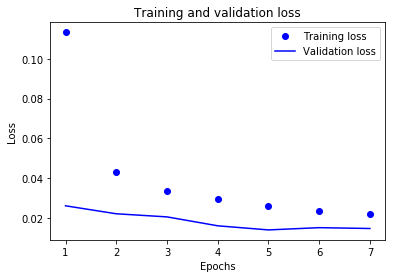

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
predictions1 = model.predict(X_test)
print(predictions1)
Get_score(predictions1, Y_test) # Try remember what the Spearman scores actually mean!


[[0.8159134  0.71471256]
 [0.8176195  0.73074275]
 [0.82033885 0.7175519 ]
 ...
 [0.83405954 0.7313785 ]
 [0.89330375 0.8322945 ]
 [0.84607834 0.77793205]]
Input shapes don't match!


**#Predicting test set model 1(CV Model)**

In [0]:
predictions1_test = model.predict(X_test)
print(predictions1_test)

[[0.8159134  0.71471256]
 [0.8176195  0.73074275]
 [0.82033885 0.7175519 ]
 ...
 [0.83405954 0.7313785 ]
 [0.89330375 0.8322945 ]
 [0.84607834 0.77793205]]




# 2. Using TFIDF Algorithm

In [0]:
tfidf=TfidfVectorizer(min_df=1, stop_words='english')

In [0]:
X_TF=tfidf.fit_transform(df['caption'])

In [0]:
#for test features
X_tfarrseq=X_TF.toarray()
X_tfarrseq

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
print(X_tfarrseq[0])

[0. 0. 0. ... 0. 0. 0.]


In [0]:
#Y=df[['short-term_memorability','long-term_memorability']].values  #targets
X=X_tfarrseq #input

In [0]:
#For test set prediction purposes

X_train = X_tfarrseq[0:6000]
X_test = X_tfarrseq[6000:]

In [0]:
#X_train, X_test = train_test_split(X, test_size=0.2, random_state=42) # random state for reproducability

**Creating a dense network with similar paramenters with few alterations**

In [0]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (6000, 5814)
X_test (2000, 5814)
Y_train (6000, 2)
Y_test (2000, 7)


In [0]:
n_cols = X_train.shape[1]
n_cols

5814

In [0]:
# Save the number of columns in predictors: n_cols


# Set up the model: model
model = Sequential()
# Add the first layer
model.add(Dense(50, activation='relu', input_shape=(n_cols,)))
model.add(Dropout(0.5))
# Add the second layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
# Add the output layer
model.add(Dense(2))

In [0]:
# Compile the model
model.compile(optimizer='adam', loss = 'mean_squared_error')

In [0]:
# Verify that model contains information from compiling
print("Loss function: " + model.loss)

Loss function: mean_squared_error


In [0]:
# Fit the model
history=model.fit(X_train, Y_train, validation_split=0.3, epochs=30, callbacks= [early_stopping_monitor])

Train on 4200 samples, validate on 1800 samples
Epoch 1/30
4200/4200 [==============================] - 2s 406us/step - loss: 0.2366 - val_loss: 0.0221
Epoch 2/30
4200/4200 [==============================] - 1s 160us/step - loss: 0.0707 - val_loss: 0.0201
Epoch 3/30
4200/4200 [==============================] - 1s 152us/step - loss: 0.0542 - val_loss: 0.0181
Epoch 4/30
4200/4200 [==============================] - 1s 152us/step - loss: 0.0461 - val_loss: 0.0164
Epoch 5/30
4200/4200 [==============================] - 1s 155us/step - loss: 0.0388 - val_loss: 0.0157
Epoch 6/30
4200/4200 [==============================] - 1s 153us/step - loss: 0.0338 - val_loss: 0.0152
Epoch 7/30
4200/4200 [==============================] - 1s 159us/step - loss: 0.0319 - val_loss: 0.0148
Epoch 8/30
4200/4200 [==============================] - 1s 153us/step - loss: 0.0299 - val_loss: 0.0137
Epoch 9/30
4200/4200 [==============================] - 1s 152us/step - loss: 0.0279 - val_loss: 0.0146
Epoch 10/30
4200

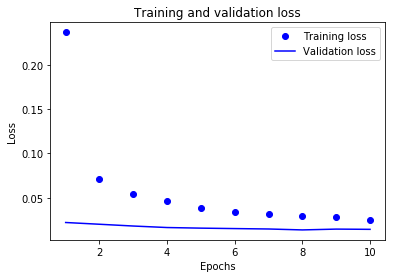

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
predictions2 = model.predict(X_test)
print(predictions2)
Get_score(predictions2, Y_test) # Try remember what the Spearman scores actually mean!

[[0.86267066 0.7962814 ]
 [0.89125776 0.8597711 ]
 [0.86001736 0.7908814 ]
 ...
 [0.9298321  0.8844288 ]
 [0.8320594  0.7101537 ]
 [0.8353752  0.73660815]]
The Spearman's correlation coefficient is: 0.385
The Spearman's correlation coefficient is: 0.219


**#Prediction test set model 2(TF-IDF)**

In [0]:
#test set predictions
predictions2_test = model.predict(X_test)
print(predictions2_test)

[[0.7963306  0.70874864]
 [0.81560373 0.7413621 ]
 [0.8311751  0.7480603 ]
 ...
 [0.8712563  0.78579706]
 [0.8782933  0.80818063]
 [0.84172744 0.7643131 ]]


#3. MEMORABILITY WITH IMAGE FEATURES

**Using Extracted HMP features**

Conveting the featured into a numpy array for dense networks.

In [0]:
result_array = np.empty((0, 6075))
for line in df['arrayInfo']:
    result_array = np.append(result_array, np.array([line]), axis = 0)
  

In [0]:
X_arrHMP = result_array
print(type(X_arrHMP))
X_arrHMP

<class 'numpy.ndarray'>


array([[1.25563e-01, 2.40360e-02, 3.14000e-04, ..., 8.60000e-05,
        5.80000e-04, 0.00000e+00],
       [7.52600e-03, 1.42100e-03, 6.80000e-05, ..., 2.20000e-04,
        7.62000e-04, 1.22400e-03],
       [1.09584e-01, 1.89780e-02, 2.89000e-04, ..., 5.20000e-05,
        2.58000e-04, 2.15000e-04],
       ...,
       [2.93470e-02, 8.07300e-03, 1.01000e-04, ..., 2.62000e-04,
        3.54000e-04, 1.13000e-04],
       [2.17460e-02, 3.09600e-03, 4.50000e-05, ..., 1.20000e-04,
        1.29000e-04, 2.00000e-05],
       [1.12070e-02, 2.82700e-03, 1.37000e-04, ..., 2.85000e-04,
        4.49000e-04, 2.32000e-04]])

In [0]:
#Y=df_hmp[['short-term_memorability','long-term_memorability']].values  #targets
X=X_arrHMP #input

In [0]:
#For test set prediction purposes

X_train = X[0:6000]
X_test = X[6000:]

Splitting the data

In [0]:
#X_train, X_test = train_test_split(X, test_size=0.2, random_state=42) 

print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (6000, 6075)
X_test (2000, 6075)
Y_train (6000, 2)
Y_test (2000, 7)


In [0]:
n_cols = X_train.shape[1]
n_cols

6075

**Adding Dense Layers**

In [0]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_cols,)))
model.add(Dropout(0.5))
# Add the second layer
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
# Add the output layer
model.add(Dense(2))

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
   
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

In [0]:
# Fit the model
history=model.fit(X_train, Y_train, validation_split=0.3, epochs=30, callbacks= [early_stopping_monitor])
# Fit the model
#history=model.fit(X_train, Y_train, validation_split=0.3, epochs=30, callbacks= [early_stopping_monitor])


Train on 4200 samples, validate on 1800 samples
Epoch 1/30
4200/4200 [==============================] - 3s 597us/step - loss: 0.1165 - acc: 0.6045 - val_loss: 0.0166 - val_acc: 0.7044
Epoch 2/30
4200/4200 [==============================] - 1s 168us/step - loss: 0.0370 - acc: 0.6045 - val_loss: 0.0145 - val_acc: 0.7044
Epoch 3/30
4200/4200 [==============================] - 1s 167us/step - loss: 0.0318 - acc: 0.6319 - val_loss: 0.0136 - val_acc: 0.7044
Epoch 4/30
4200/4200 [==============================] - 1s 170us/step - loss: 0.0276 - acc: 0.6498 - val_loss: 0.0136 - val_acc: 0.7044
Epoch 5/30
4200/4200 [==============================] - 1s 165us/step - loss: 0.0249 - acc: 0.6748 - val_loss: 0.0149 - val_acc: 0.7044


Predictions

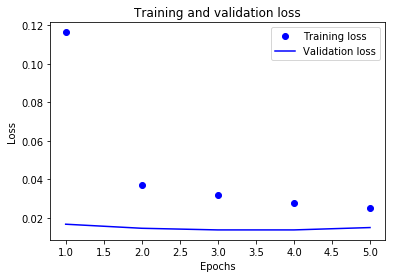

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
#Code while working on training sets
#predictions3 = model.predict(X_test)
#print(predictions3)
#Get_score(predictions3, Y_test) 

[[0.8824937  0.8067748 ]
 [0.8534366  0.78048277]
 [0.88414556 0.8081053 ]
 ...
 [0.8750478  0.79944754]
 [0.8706015  0.79562926]
 [0.86146355 0.78789926]]
The Spearman's correlation coefficient is: 0.272
The Spearman's correlation coefficient is: 0.121


**#Prediction Test-set Model 3(HMP features)**

In [0]:
#test set predictions
predictions3_test = model.predict(X_test)
print(predictions3_test)

[[0.8055661  0.73707354]
 [0.8235383  0.7546    ]
 [0.8501699  0.7774588 ]
 ...
 [0.82657117 0.75577855]
 [0.8027139  0.7361328 ]
 [0.8261422  0.7558769 ]]


#Creating an ensemble model using simple average method

For predicting test features

In [0]:
predictions_test = np.add(predictions1_test,predictions2_test)
predictions_test = np.add(predictions_test,predictions3_test)

In [0]:
print(predictions_test)

[[2.41781   2.1605349]
 [2.4567616 2.2267048]
 [2.5016837 2.243071 ]
 ...
 [2.531887  2.272954 ]
 [2.5743108 2.376608 ]
 [2.513948  2.298122 ]]


In [0]:
predictions_test = np.divide(predictions_test, 3)

In [0]:
predictions_test.shape

(2000, 2)

**Final Predictions using Ensemble**

In [0]:
print(predictions_test)

[[0.80593663 0.7201783 ]
 [0.81892055 0.74223495]
 [0.83389455 0.7476904 ]
 ...
 [0.8439624  0.7576513 ]
 [0.8581036  0.79220265]
 [0.83798265 0.7660406 ]]


**Extracting the results in a csv**

In [0]:
df_test_results = pd.DataFrame(columns = ['video', 'short-term', 'long-term'])
df_test_results['short-term'] = predictions_test[:,0]
df_test_results['long-term'] = predictions_test[:,1]
df_test_results['video'] = df['video'][6000:]

In [0]:
df_test_results.head()

,video,short-term,long-term
0,video7494.webm,0.805937,0.720178
1,video7495.webm,0.818921,0.742235
2,video7496.webm,0.833895,0.747690
3,video7497.webm,0.816705,0.731055
4,video7498.webm,0.796845,0.711079


In [0]:
df_test_results.to_csv('test-results.csv')
from google.colab import files
files.download("test-results.csv")

In [0]:
#pred_out = model.predict(X_test)
print(predictions)
Get_score(predictions, Y_test) 

[[0.88084483 0.78479487]
 [0.86364746 0.81410617]
 [0.8714673  0.805489  ]
 ...
 [0.89197254 0.83532816]
 [0.8510886  0.7336438 ]
 [0.8463002  0.7388862 ]]
The Spearman's correlation coefficient is: 0.452
The Spearman's correlation coefficient is: 0.218


#Create an ensemble using Weighted Average method

**Didn't use it for final predictions**

In [0]:
predictions_weighted  = 0.40*predictions1 + 0.40*predictions2 + 0.10*predictions3

In [0]:
print(predictions_weighted)

[[0.7922657  0.69972146]
 [0.7803459  0.74278253]
 [0.7805171  0.72415525]
 ...
 [0.80785275 0.7625596 ]
 [0.7601259  0.64168376]
 [0.7571212  0.65029365]]


In [0]:
#pred_out = model.predict(X_test)
print(predictions_weighted)
Get_score(predictions_weighted, Y_test) # Try remember what the Spearman scores actually mean!

[[0.7922657  0.69972146]
 [0.7803459  0.74278253]
 [0.7805171  0.72415525]
 ...
 [0.80785275 0.7625596 ]
 [0.7601259  0.64168376]
 [0.7571212  0.65029365]]
The Spearman's correlation coefficient is: 0.441
The Spearman's correlation coefficient is: 0.213
